In [ ]:
# https://github.com/bnsreenu/python_for_microscopists/blob/master/255_256_SRGAN/SRGAN_train.py
# https://github.com/bnsreenu/python_for_microscopists/blob/master/255_256_SRGAN/SRGAN_flickr_prepare_dataset.py

# https://www.youtube.com/watch?v=nbRkLE2fiVI&list=PLZsOBAyNTZwboR4_xj-n3K6XBTweC4YVD&index=12

# https://github.com/bnsreenu/python_for_microscopists/tree/master/255_256_SRGAN

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#########################################################################

In [ ]:
#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [ ]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


In [ ]:
"""
16 identical residual blocks same as paper
"""
num_res_block=16

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [ ]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [ ]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
"""
+1
"""
###################################################################################

#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import vgg19

def build_vgg(hr_shape):
    
    vgg = vgg19.VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
"""
+1
"""
###################################################################################

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

"""
validity = adversarial loss
gen_features = content loss (using vgg19)
"""

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

'\nvalidity = adversarial loss\ngen_features = content loss (using vgg19)\n'

In [ ]:
"""
+1
"""
###################################################################################
"""
"""
# Mounting the google colab drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
"""
+1
"""
###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
"""
"""
#n=5000
"""
"""
n=250

lr_list = os.listdir("/content/drive/MyDrive/Xccelerate/SRGAN/lr_images")[:n]

hr_list = os.listdir("/content/drive/MyDrive/Xccelerate/SRGAN/hr_images")[:n]

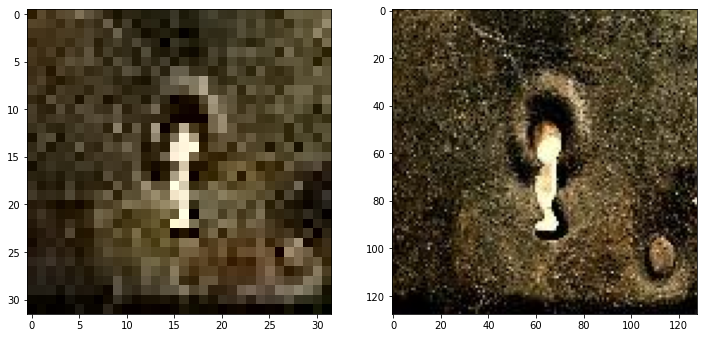

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
"""
+1
"""
###################################################################################

from keras.applications import vgg19
###################################################################################

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/Xccelerate/SRGAN/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/content/drive/MyDrive/Xccelerate/SRGAN/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/Xccelerate/SRGAN/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,test_size=0.33, random_state=42) 

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [ ]:
"""
##########################################################################
"""



"""
##########################################################################
"""

'\n##########################################################################\n'

In [ ]:
"""
xxxx
"""
###################################################################################
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
"""
number of epochs = 10
"""    
epochs = 10
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/Xccelerate/SRGAN/"+ str(e+1) +".h5")
# generator.save("gen_e_"+ str(e+1) +".h5")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

100%|██████████| 167/167 [12:00<00:00,  4.32s/it]


epoch: 1 g_loss: 127.59544988163931 d_loss: [6.02951705 0.66167665]


100%|██████████| 167/167 [11:46<00:00,  4.23s/it]


epoch: 2 g_loss: 86.76631530030758 d_loss: [0.6692774  0.89221557]


100%|██████████| 167/167 [11:56<00:00,  4.29s/it]


epoch: 3 g_loss: 81.03504640042425 d_loss: [0.77218723 0.88323353]


100%|██████████| 167/167 [11:57<00:00,  4.30s/it]


epoch: 4 g_loss: 74.73745766942372 d_loss: [2.22943178 0.75149701]


100%|██████████| 167/167 [12:02<00:00,  4.33s/it]


epoch: 5 g_loss: 71.64772969091723 d_loss: [0.80506992 0.86526946]


100%|██████████| 167/167 [12:14<00:00,  4.40s/it]


epoch: 6 g_loss: 69.24715004424135 d_loss: [0.86259081 0.84431138]


100%|██████████| 167/167 [11:58<00:00,  4.30s/it]


epoch: 7 g_loss: 68.03483305148735 d_loss: [0.47137236 0.87724551]


100%|██████████| 167/167 [12:06<00:00,  4.35s/it]


epoch: 8 g_loss: 66.65545580629816 d_loss: [0.52786384 0.9011976 ]


100%|██████████| 167/167 [11:38<00:00,  4.18s/it]


epoch: 9 g_loss: 67.89887893128538 d_loss: [0.98622361 0.87125749]


100%|██████████| 167/167 [11:21<00:00,  4.08s/it]

epoch: 10 g_loss: 64.49026218003142 d_loss: [0.72530303 0.89221557]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


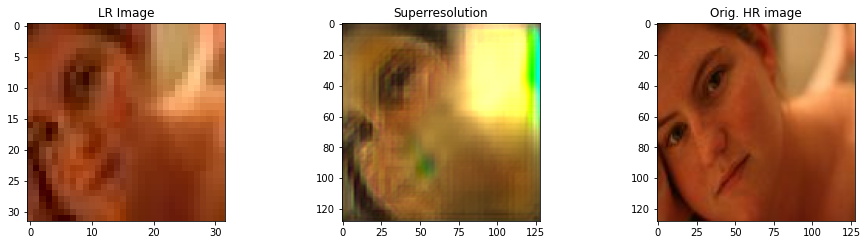

In [ ]:
"""
+1
"""
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Xccelerate/SRGAN/10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
###################################################################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


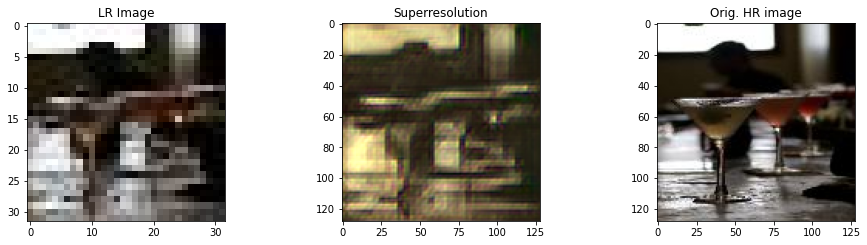

In [ ]:
"""
+1
"""
###################################################################################
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()
###################################################################################

In [ ]:
################################################
"""

"""
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

In [ ]:
##############################################################################
##############################################################################
##############################################################################

In [ ]:
# https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc
"""
Single Image Super-Resolution Using SRGAN

Original paper: https://arxiv.org/pdf/1609.04802.pdf

Dataset from:
    http://press.liacs.nl/mirflickr/mirdownload.html
    
All images resized to 128x128 to represent HR and 32x32 to represent LR.

"""


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#########################################################################

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

###################################################################################

#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 5000 images
n=5000
lr_list = os.listdir("data/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 5
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


################################################
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()

ImportError: ignored

In [ ]:
##################################################################################################
# https://github.com/bnsreenu/python_for_microscopists/blob/master/255_256_SRGAN/SRGAN_flickr_prepare_dataset.py
##################################################################################################

In [ ]:
# # https://youtu.be/nbRkLE2fiVI
# https://youtu.be/1HqjPqNglPc
"""


Dataset from: http://press.liacs.nl/mirflickr/mirdownload.html

Read high res. original images and save lower versions to be used for SRGAN.

Here, we are resizing them to 128x128 that will be  used as HR images and 
32x32 that will be used as LR images
"""

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

train_dir = "data" 

for img in os.listdir( train_dir + "/original_images"):
    img_array = cv2.imread(train_dir + "/original_images/" + img)
    
    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)


In [ ]:
##################################################################################################

##################################################################################################

In [ ]:
##################################################################################################
# https://github.com/bnsreenu/python_for_microscopists/blob/master/224_225_226_mito_segm_using_various_unet_models.py
##################################################################################################

In [ ]:
# https://youtu.be/L5iV5BHkMzM
"""
Mitochondria semantic segmentation using U-net, Attention Unet and Att Res Unet

Author: Dr. Sreenivas Bhattiprolu

Dataset from: https://www.epfl.ch/labs/cvlab/data/data-em/
Images and masks are divided into patches of 256x256. 
"""

import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers


image_directory = 'data/images/'
mask_directory = 'data/masks/'


SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.

images = os.listdir(image_directory)
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'tif'):
        #print(image_directory+image_name)
        image = cv2.imread(image_directory+image_name, 1)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

#Iterate through all images in Uninfected folder, resize to 64 x 64
#Then save into the same numpy array 'dataset' but with label 1

masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))


#Normalize images
image_dataset = np.array(image_dataset)/255.
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

#######################################
#Parameters for model

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

###############################################################################


#Try various models: Unet, Attention_UNet, and Attention_ResUnet
#Rename original python file from 224_225_226_models.py to models.py
from models import Attention_ResUNet, UNet, Attention_UNet, dice_coef, dice_coef_loss, jacard_coef

'''
UNet
'''
unet_model = UNet(input_shape)
unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


print(unet_model.summary())

start1 = datetime.now() 
unet_history = unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=50)

stop1 = datetime.now()
#Execution time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

unet_model.save('mitochondria_UNet_50epochs_B_focal.hdf5')
#____________________________________________
'''
Attention UNet
'''
att_unet_model = Attention_UNet(input_shape)

att_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


print(att_unet_model.summary())
start2 = datetime.now() 
att_unet_history = att_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=50)
stop2 = datetime.now()
#Execution time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

att_unet_model.save('mitochondria_Attention_UNet_50epochs_B_focal.hdf5')

#___________________________________________
'''
Attention Residual Unet
'''
att_res_unet_model = Attention_ResUNet(input_shape)

att_res_unet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])


# att_res_unet_model.compile(optimizer=Adam(lr = 1e-3), loss='binary_crossentropy', 
#               metrics=['accuracy', jacard_coef])

print(att_res_unet_model.summary())


start3 = datetime.now() 
att_res_unet_history = att_res_unet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=50)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResUnet = stop3-start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

att_res_unet_model.save('mitochondria_AttResUnet_50epochs_B_focal.hdf5')

############################################################################
# convert the history.history dict to a pandas DataFrame and save as csv for
# future plotting
import pandas as pd    
unet_history_df = pd.DataFrame(unet_history.history) 
att_unet_history_df = pd.DataFrame(att_unet_history.history) 
att_res_unet_history_df = pd.DataFrame(att_res_unet_history.history) 

with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)
    
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f)

with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    att_res_unet_history_df.to_csv(f)    

#######################################################################
#Check history plots, one model at a time
history = unet_history
history = att_unet_history
history = att_res_unet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

#######################################################



model = unet_model
model = att_unet_model
model = att_res_unet_model

model_path = "models/mitochondria_UNet_50epochs_B_focal.hdf5"
model_path = "models/mitochondria_Attention_UNet_50epochs_B_focal.hdf5"
model_path = "models/mitochondria_AttResUnet_50epochs_B_focal.hdf5"
#Load one model at a time for testing.
model = tf.keras.models.load_model(model_path, compile=False)


import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


#Calculate IoU for all test images and average
 
import pandas as pd

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)    
    




In [ ]:
##################################################################################################

##################################################################################################

In [ ]:
##################################################################################################
# https://github.com/bnsreenu/python_for_microscopists/blob/master/224_225_226_models.py
##################################################################################################

In [ ]:
# https://youtu.be/L5iV5BHkMzM
"""

Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf

Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)

Note: Batch normalization should be performed over channels after a convolution, 
In the following code axis is set to 3 as our inputs are of shape 
[None, height, width, channel]. Channel is axis=3.

Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn




def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

input_shape = (256,256,1)
UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True)

In [ ]:
##################################################################################################

##################################################################################################

In [ ]:
##################################################################################################

##################################################################################################

In [ ]:
##################################################################################################

##################################################################################################